#### Import and Global Variables

In [12]:
from feature_extractors.transformer_feature_extractor import TransformerFeatureExtractor
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import random
from tqdm import tqdm
from scipy.stats import ttest_ind


seed = 42

### Extract features

In [2]:

if os.path.exists('./pickles/pickled_datasets/seed_42/out_of_domain_X_bigbird_chunks.pkl'):
    X_chunks = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_X_bigbird_chunks.pkl', 'rb'))

else:
    feature_extractor_chunks = TransformerFeatureExtractor('./fine_tuned_models/out_of_domain_bigbird_roberta_base_clean_chunks')
    data_chunks = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_experiment_dataset_clean_chunks.pkl', 'rb'))
    X_chunks = feature_extractor_chunks.transform(data_chunks.get_dataframe().text.values.tolist())

if os.path.exists('./pickles/pickled_datasets/seed_42/out_of_domain_X_bigbird_users.pkl'): 
    X_users = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_X_bigbird_users.pkl', 'rb'))
    
else:
    feature_extractor_users = TransformerFeatureExtractor('./fine_tuned_models/out_of_domain_bigbird_roberta_base_clean_users')
    data_users = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_experiment_dataset_clean_users.pkl', 'rb'))
    X_users = feature_extractor_users.transform(data_users.get_dataframe().text.values.tolist())


y_chunks = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_y_bigbird_chunks.pkl', 'rb'))
y_users = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_y_bigbird_users.pkl', 'rb'))


#### Add author names to users split

In [3]:
users_split_df = pickle.load(open('./pickles/pickled_datasets/seed_42/out_of_domain_experiment_dataset_clean_users.pkl', 'rb')).get_dataframe()
author_names = users_split_df.author_name.values.reshape(-1, 1)
X_users = pd.DataFrame(np.concatenate([X_users, author_names], axis=1), columns=['feature_'+str(i) for i in range(X_users.shape[1])] + ['author_name'])

y_users = pd.DataFrame(np.concatenate([y_users.reshape(-1, 1), author_names], axis=1), columns=['label', 'author_name'])
y_users['label'] = y_users['label'].astype(int)


### Cross Validation

In [4]:
random.seed(seed)

k = 10

indices = [i for i in range(len(X_chunks))]
random.shuffle(indices)

author_names = np.unique(X_users.author_name.values)
random.shuffle(author_names)

fold_indices = np.array_split(np.array(indices), k)
fold_author_names = np.array_split(np.array(author_names), k)

cv_accuracy_chunks = []
cv_accuracy_users = []

confusion_matrices_chunks = []
confusion_matrices_users = []

for i in tqdm(range(k), desc='Cross validation'):
    test_indices = fold_indices[i]
    train_indices = [index for index in indices if index not in test_indices]

    test_names = fold_author_names[i]
    train_names = [name for name in author_names if name not in test_names]

    clf_chunks = LogisticRegression(random_state=seed, max_iter=10000).fit(X_chunks[train_indices, :], y_chunks[train_indices])
    clf_users = LogisticRegression(random_state=seed, max_iter=10000).fit(X_users.loc[X_users.author_name.isin(train_names), :].drop('author_name', axis=1).values,
                                                                          y_users.loc[y_users.author_name.isin(train_names), 'label'].values)

    preds_chunks = clf_chunks.predict(X_chunks[test_indices, :])
    preds_users = clf_users.predict(X_users.loc[X_users.author_name.isin(test_names), :].drop('author_name', axis=1).values)

    cv_accuracy_chunks.append(accuracy_score(y_chunks[test_indices], preds_chunks))
    cv_accuracy_users.append(accuracy_score(y_users.loc[y_users.author_name.isin(test_names), 'label'].values, preds_users))

    confusion_matrices_chunks.append(confusion_matrix(y_chunks[test_indices], preds_chunks))
    confusion_matrices_users.append(confusion_matrix(y_users.loc[y_users.author_name.isin(test_names), 'label'].values, preds_users))

Cross validation: 100%|██████████| 10/10 [01:54<00:00, 11.46s/it]


### Visualize Accuracy Scores

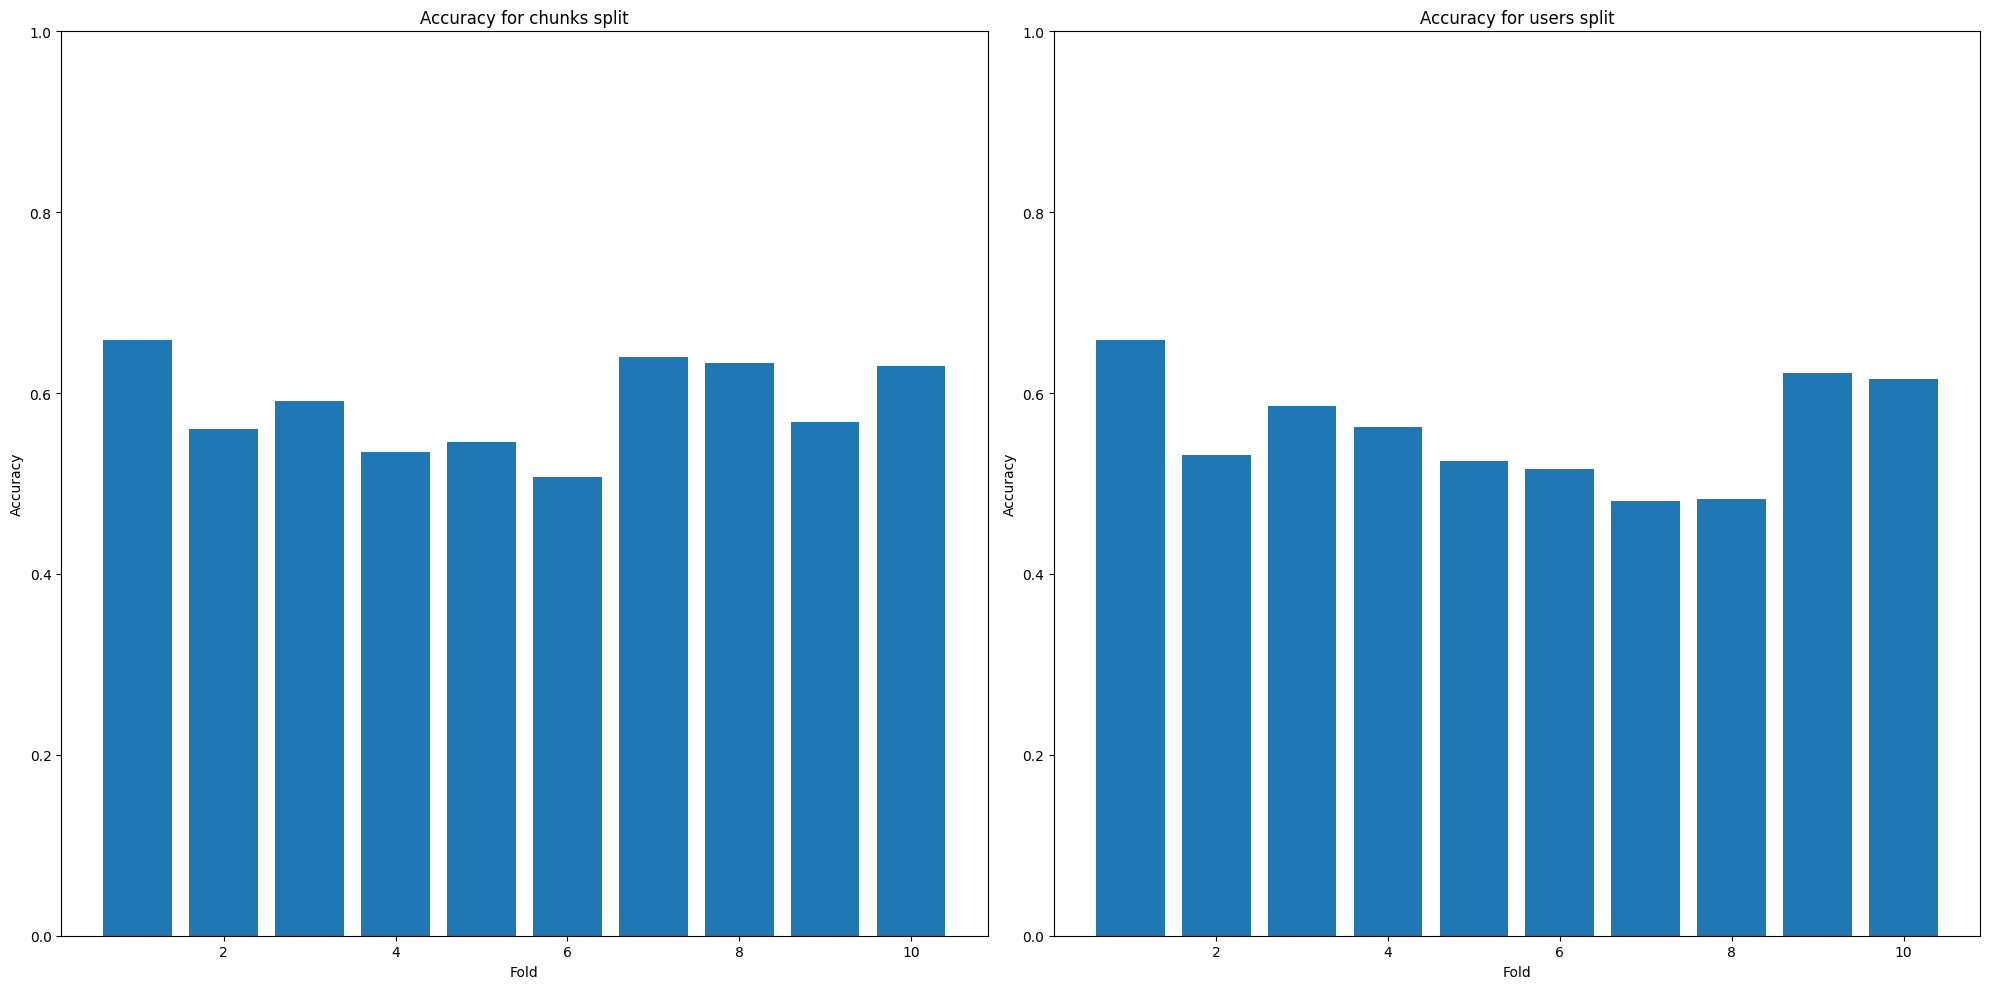

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].bar([i for i in range(1, k + 1)], cv_accuracy_chunks)
ax[0].set_title('Accuracy for chunks split')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)

ax[1].bar([i for i in range(1, k + 1)], cv_accuracy_users)
ax[1].set_title('Accuracy for users split')
ax[1].set_xlabel('Fold') 
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


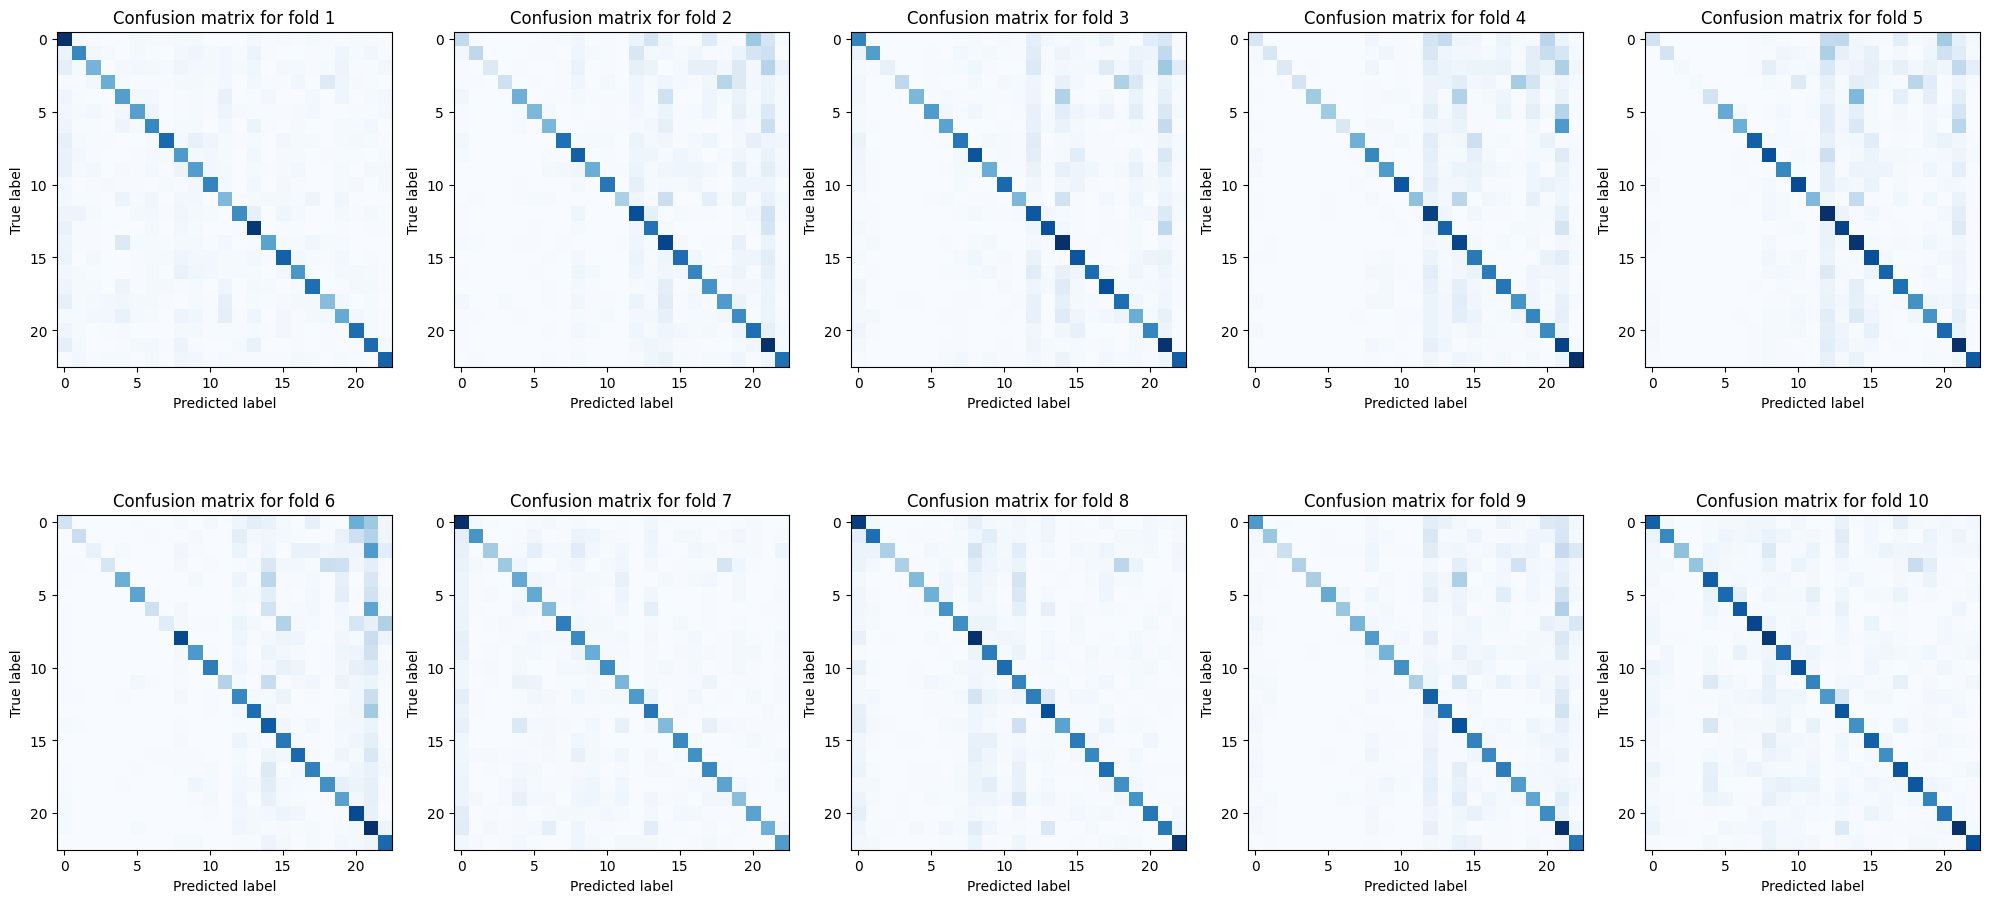

In [10]:
# Plot the confusion matrices with titles
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(confusion_matrices_chunks[i*5 + j], cmap=plt.cm.Blues)
        ax[i, j].set_title('Confusion matrix for fold {}'.format(i*5 + j + 1))
        ax[i, j].set_xlabel('Predicted label')
        ax[i, j].set_ylabel('True label')
        
plt.tight_layout()
plt.show()

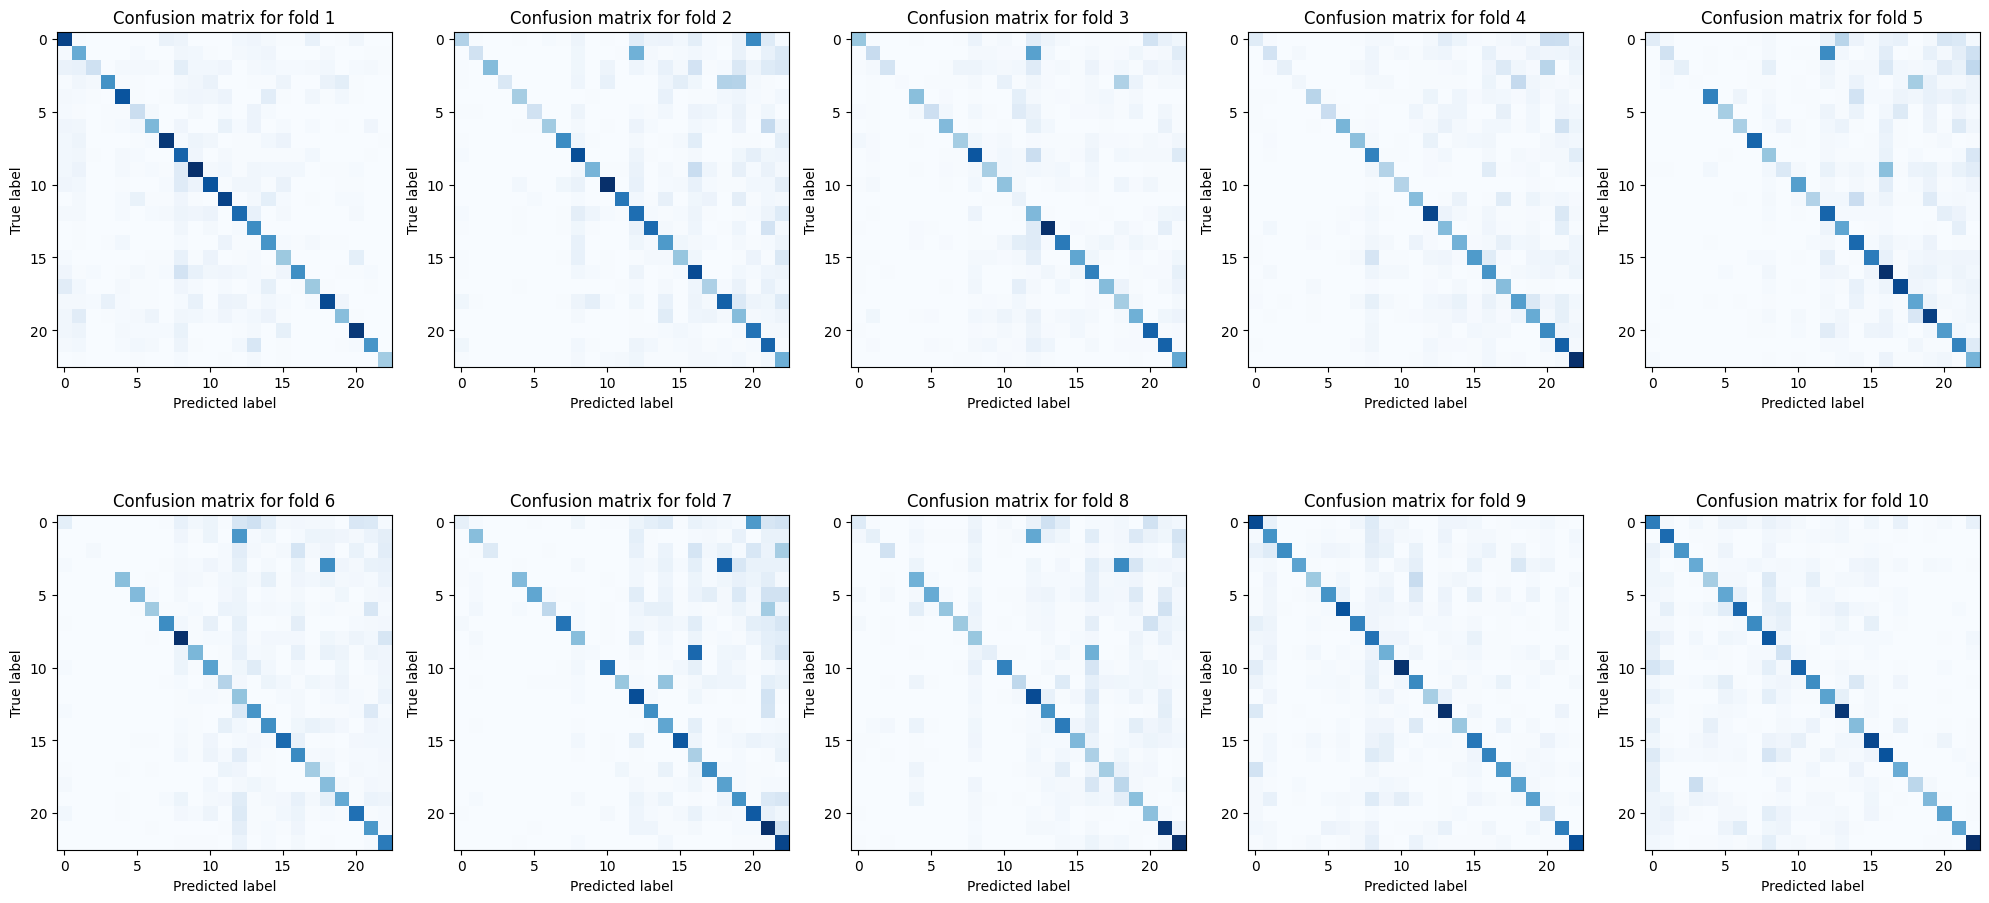

In [9]:
# Plot the confusion matrices with titles
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(confusion_matrices_users[i*5 + j], cmap=plt.cm.Blues)
        ax[i, j].set_title('Confusion matrix for fold {}'.format(i*5 + j + 1))
        ax[i, j].set_xlabel('Predicted label')
        ax[i, j].set_ylabel('True label')
        
plt.tight_layout()
plt.show()

### Test Difference in Accuracies

In [13]:
# Conduct a paired t-test to see if the difference between the accuracies is significant

t, p = ttest_ind(cv_accuracy_chunks, cv_accuracy_users)

t, p # There is no significant difference between the accuracies

(1.1401215451159257, 0.2691799050981626)